# Non-inferencing gates by recurrent NN

Notebook for the example in figure 2 of https://arxiv.org/abs/1905.05264

## Initial setup

In [5]:
import sys
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime

from utilitiesquantumgates import quantumgates 
from utilitiesquantumgates import utilities
from tensorboardutilities import tensorboardutilities
from datetime import datetime
from stoppingRoutines import Stopper

#%% set datatype
datatype=np.complex64

#%% set the tensorboard utilities
tensorboarddir = tensorboardutilities.getdirname();

#%% random seed 
timestamp = int(time.mktime(datetime.now().timetuple()))
RANDOM_SEED=timestamp
# seed random number generation
tf.set_random_seed(RANDOM_SEED)
np.random.seed(seed=RANDOM_SEED)


## Hyperparameters 

In [6]:
#%% relaxation parameter
mu=100
#%% numer of dimensions
N=3

## Target matrix

In [7]:
XT=tf.constant(quantumgates.Xgate(N,datatype))

## Random medium matrix and other matrix and functions for the model

In [8]:
U=tf.constant(quantumgates.randomU(N),datatype)

TU=tf.transpose(U,conjugate=True)
#%% neutral matrxi
Neutral=tf.constant(np.zeros([N,N]),dtype=datatype)

#%% identity matrix
IE=tf.eye(N,dtype=datatype)

#%% solution matrix, initially set to zero
W0=tf.constant(np.zeros([N, N]),dtype=datatype)

#%%relaxation
tfmu=tf.constant(mu,dtype=np.float64)

#%% function F 
def fun(W):
    tmp=tf.matmul(U,W)-XT
    return tmp

#%% flux    
def flux(W,t):
    return -tf.scalar_mul(mu,tf.matmul(U,fun(W),adjoint_a=True))

## Setup ode integrator ##

In [9]:
#%% ode integrator
points=200    
t=np.linspace(0,1.1,num=points)
tensor_state, tensor_info = tf.contrib.integrate.odeint(
            flux, W0, t, rtol=1e-04, atol=1e-06,full_output=True,method='dopri5')
Wfinal=tensor_state[-1,:,:]
Xfinal=tf.matmul(U,Wfinal)
Gfinal=fun(Wfinal)


#%% error function
error=tf.reduce_mean(tf.abs(fun(Wfinal)))

## Run TF Session with plots and error ##

Structure matrix U
[[-0.5-0.3j -0.4+0.1j  0.7+0.1j]
 [-0.1-0.5j -0.6+0.2j -0.5-0.4j]
 [-0.6-0.1j  0.3-0.7j -0.2-0.2j]]
Solution Wf
[[-0.6+0.1j -0.5+0.3j -0.1+0.5j]
 [ 0.3+0.7j -0.4-0.1j -0.6-0.2j]
 [-0.2+0.2j  0.7-0.1j -0.5+0.4j]]
Check (must be equal to the target matrix) 
[[ 1.7e-06+3.7e-07j  1.0e+00-1.8e-07j  8.5e-07-1.3e-06j]
 [ 3.2e-07+2.1e-06j -7.5e-07-1.3e-06j  1.0e+00+1.2e-07j]
 [ 1.0e+00-2.3e-07j -6.3e-07-1.5e-06j -7.3e-08+7.5e-07j]]
Target 
[[0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j]
 [1.+0.j 0.+0.j 0.+0.j]]
Final error 
3.3690274e-05


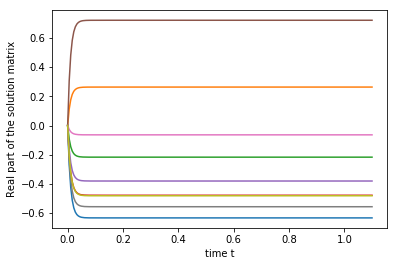

In [12]:
with tf.Session()  as sess:
    sess.run(tf.global_variables_initializer())
    print('Structure matrix U')
    print(U.eval())
    state, info = sess.run([tensor_state, tensor_info])
    Wf, Xf, Gf, ef = sess.run([Wfinal, Xfinal, Gfinal, error])

    # plot the ode solution (this plot gives a warning message because is the plot of complex quantitis)
    u13t=state.T # transpose
    for i1 in range(N):
        for i2 in range(N):
           plt.plot(t,np.real(u13t[i1,i2,:]))
    plt.ylabel('Real part of the solution matrix')
    plt.xlabel('time t')
    # export the figure in eps
    plt.savefig('trainingnumpy.eps', format='eps', dpi=1000)

    
    print('Solution Wf')
    np.set_printoptions(precision=1)
    print(Wf)
    print('Check (must be equal to the target matrix) ')    
    np.set_printoptions(precision=1)
    print(Xf)
    print('Target ')
    print(XT.eval())
    
    print('Final error ')
    print(ef)
        
#%%
sess.close()